In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from scipy.sparse import csr_matrix, hstack, vstack, csc_matrix
from nltk.stem import PorterStemmer
import scipy as sc
from sklearn.preprocessing import OneHotEncoder
import pymorphy2 

In [10]:
train = pd.read_csv('train.txt', sep=', ', header=None)
train.columns = ['word', 'y']
#train = train.sample(frac=0.1, random_state=42)

test = pd.read_csv('test.txt', header=None)
test.columns = ['word']

submission_example = pd.read_csv('submission_example.txt', sep=',')

/home/pavel/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  if __name__ == '__main__':


In [ ]:
morph = pymorphy2.MorphAnalyzer()
train['word'] = map(lambda x: morph.parse(x.decode('utf-8'))[0].normal_form, train.word.values)
test['word'] = map(lambda x: morph.parse(x.decode('utf-8'))[0].normal_form, test.word.values)

In [12]:
capital_elems = []
for i in range(len(train)):
    capital_elems.append(1 if train.word.values[i].decode('utf-8').istitle() else 0)
capital_elems = np.array(capital_elems)

In [13]:
w_length = []
for word in train.word.values:
    w_length.append(len(word))
w_length = np.array(w_length)

In [14]:
new_words = []
for word in train.word.values:
    new_words.append(word.decode('utf-8').lower()[-3:])    

train.word = new_words

In [15]:
cv = CountVectorizer(input='content', analyzer='char_wb', ngram_range=(1, 10), lowercase = True)
X = cv.fit_transform(train.word) 
y = train.y.values

In [16]:
X = hstack([X, csr_matrix(capital_elems).transpose(), csr_matrix(w_length).transpose()])

In [9]:
def cross_validation(clf, X=X, y=y, verbose=True):
    cv = StratifiedKFold(n_splits=5)
    scores = []
    for train, test in cv.split(X, y):
        clf.fit(X[train], y[train])
        scores.append(roc_auc_score(y[test], clf.predict_proba(X[test])[:,1]))
        if verbose:
            print 'here'
    return np.mean(scores)

def cross_validation_sp(clf, X=X, y=y):
    cv = StratifiedKFold(n_splits=5)
    scores = []
    for train, test in cv.split(X, y):
        clf.fit(train)
        scores.append(roc_auc_score(y[test], clf.predict_proba(test)[:,1]))
        print 'here'
    return np.mean(scores)

In [29]:
class av_proba_clf:
    def __init__(self):
        self.clf = [RandomForestClassifier(n_estimators=35, min_samples_split=100), 
                    ExtraTreesClassifier(n_estimators=45, min_samples_split=100)]
    
    def fit(self, X, y):
        for i in range(len(self.clf)):
            a = len(X)/float(len(self.clf))
            self.clf[i].fit(X[i*a: (i+1)*a], y[i*a: (i+1)*a])
            
    def predict_proba(self, X):
        proba = np.zeros((len(X), 2))
        for clf in self.clf:
            proba += clf.predict_proba(X)
        return proba/len(self.clf)

In [17]:
print np.mean(cross_val_score(LogisticRegression(C=10), X, y, scoring='roc_auc'))

0.852819553882


In [10]:
from sklearn.linear_model import SGDClassifier

print cross_validation(SGDClassifier(loss='log', alpha=0.0005))

MemoryError: 

In [125]:
print cross_validation(av_proba_clf())

/home/pavel/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


here
here
here
here
here
0.874217262049


In [131]:
print cross_validation(RandomForestClassifier(n_estimators=35, min_samples_split=100, oob_score=True))

here
here
here
here
here
0.884982287787


In [128]:
print cross_validation(RandomForestClassifier(n_estimators=35, min_samples_split=100, criterion='entropy'))

here
here
here
here
here
0.884848603143


In [66]:
print cross_validation(ExtraTreesClassifier(n_estimators=45, min_samples_split=100))

here
here
here
here
here
0.884539070724


40 0.884051765145
50 0.884997581055
60 0.885135512025
70 0.885746888872
80 0.884890103284
90 0.885185236706
100 0.884812949872
110 0.884898218123
0.885746888872 70


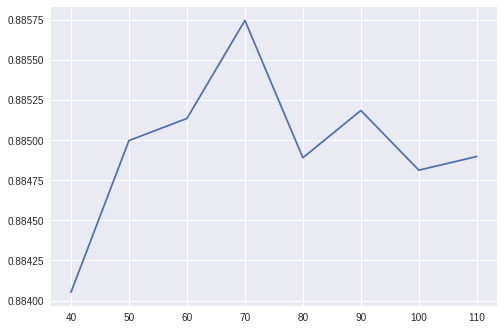

In [67]:
score = []
c_range = range(40, 120, 10)
for c in c_range:
    score.append(cross_validation(RandomForestClassifier(n_estimators=35, min_samples_split=c), verbose=False))
    print c, score[-1]
    
index = np.argmax(score)
print score[index], c_range[index]
plt.plot(c_range, score)
plt.show()

<font color='red'> <h3> Для логистической регрессии при с=6.6 score=0.674729800981 (cv=5) </h3> </font>
<font color='red'> <h3> my_clf score=0.75977841766729592 </h3> </font> <br>
<font color='red'> <h3> GB score=0.8428 </h3> </font> <br>
<h2> + фамилии </h2>
<font color='red'> <h3> my_clf score=0.766399253731  </h3> </font>
<font color='red'> <h3> LR 0.733970149254 C=0.002</h3> </font>
<font color='red'> <h3> RF 0.761295793758 n=23</h3> </font>
<font color='red'> <h3> (RF n=23) + (LR C=0.002) 0.779085142469 </h3> </font>

<font color='blue'> <h3> XGboost </h3> </font>

In [1]:
from xgboost import XGBClassifier

ImportError: No module named xgboost

In [8]:
class my_clf:
    def __init__(self):
        self.LR = LogisticRegression(C=6.6)
        self.RF = RandomForestClassifier()
    
    def fit(self, train):
        self.LR.fit(X[train], y[train])
        preds = self.LR.predict(X[train])
        self.RF.fit(np.c_[preds, capital_elems[train]], y[train])
    
    def predict(self, test):
        return self.RF.predict(np.c_[self.LR.predict(X[test]), capital_elems[test]])
    
    def predict_proba(self, test):
        return self.RF.predict_proba(np.c_[self.LR.predict(X[test]), capital_elems[test]])

In [9]:
cross_validation_sp(my_clf())

here
here
here
here
here


0.76091568305154111

In [12]:
cross_validation(LogisticRegression(C=6.6))

here
here
here
here
here


0.67471889133031837

In [14]:
print len(train[train.y==1]), len(train[train.y==0])

10638 90770


<h2> Добавляем данные </h2>

In [136]:
class my_clf:
    def __init__(self):
        self.LR = LogisticRegression(C=0.02)
        self.RF = RandomForestClassifier()
    
    def fit(self, X, y):
        self.LR.fit(X, y)
        preds = self.LR.predict(X)
        self.RF.fit(np.c_[preds, capital_elems_train], y)
    
    def predict(self, X):
        return self.RF.predict(np.c_[self.LR.predict(X), capital_elems_test])
    
    def predict_proba(self, X):
        return self.RF.predict_proba(np.c_[self.LR.predict(X), capital_elems_test])

In [73]:
test, aug_train = train[:len(train)/20], train[len(train)/20:] 

In [74]:
surnames = pd.read_csv('surnames.txt', header=None)
surnames.columns = ['word']
surnames['y'] = 1

In [75]:
aug_train = pd.concat([aug_train, surnames], axis=0)

In [76]:
capital_elems_train = []
for i in range(len(aug_train)):
    capital_elems_train.append(1 if unicode(aug_train.word.values[i], 'utf-8').istitle() else 0)
capital_elems_train = np.array(capital_elems_train)

capital_elems_test = []
for i in range(len(test)):
    capital_elems_test.append(1 if unicode(test.word.values[i], 'utf-8').istitle() else 0)
capital_elems_test = np.array(capital_elems_test)

In [77]:
all_data = pd.concat([aug_train, test])

In [78]:
cv = CountVectorizer(input='content', analyzer='char_wb')
X_all = cv.fit_transform(all_data.word) 
X_train, X_test = X_all[:len(aug_train)], X_all[len(aug_train):]
y_train, y_test = all_data.y.values[:len(aug_train)], all_data.y.values[len(aug_train):] 

In [137]:
clf = my_clf()
clf.fit(X_train, y_train)
print roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

0.766399253731


In [16]:
score = []
c_range = range(100, 200, 10)
for c in c_range:
    clf = GradientBoostingClassifier(n_estimators=c, loss='exponential')
    clf.fit(X, y)
    score.append(roc_auc_score(y, clf.predict_proba(X)[:,1]))
    print c, score[-1]

KeyboardInterrupt: 

In [ ]:
index = np.argmax(score)
print score[index], c_range[index]

In [ ]:
plt.plot(c_range, score)
plt.show()

In [119]:
clf = GradientBoostingClassifier(loss='exponential')
clf.fit(X_train.toarray(), y_train)
print roc_auc_score(y_test, clf.predict_proba(X_test.toarray())[:,1]) 

0.762442672999


In [118]:
clf = GradientBoostingClassifier()
clf.fit(X_train.toarray(), y_train)
print roc_auc_score(y_test, clf.predict_proba(X_test.toarray())[:,1]) 

0.757455054274


In [123]:
clf = RandomForestClassifier()
clf.fit(X_train.toarray(), y_train)
print roc_auc_score(y_test, clf.predict_proba(X_test.toarray())[:,1]) 

clf = RandomForestClassifier(min_samples_split=2)
clf.fit(X_train.toarray(), y_train)
print roc_auc_score(y_test, clf.predict_proba(X_test.toarray())[:,1]) 

clf = RandomForestClassifier(min_samples_split=3)
clf.fit(X_train.toarray(), y_train)
print roc_auc_score(y_test, clf.predict_proba(X_test.toarray())[:,1]) 

clf = RandomForestClassifier(min_samples_split=4)
clf.fit(X_train.toarray(), y_train)
print roc_auc_score(y_test, clf.predict_proba(X_test.toarray())[:,1]) 

0.740201153324
0.743988975577
0.757141621438
0.745103799186
